# Fitting an ODE model to longitudinal data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
import string
import pickle
from tqdm import tqdm
from datetime import datetime
#from lmfit import minimize, Parameters
#import multiprocess as mp

# Import my own libraries
import myUtils as utils
from odeModelClass import ODEModel
from odeModels import create_model
#from fittingUtils import residual, compute_r_sq, load_fit, generate_fitSummaryDf, perform_bootstrap, \
#                            compute_confidenceInterval_prediction, compute_confidenceInterval_parameters

### Cell cycle model

In [8]:
myModel = create_model("CellCycleModel")
#myModel.SetParams(G10=1500*0.458, S0=1500*0.133, SD0=1500*0.0157, G20=1500*0.391, G2D0=1500*0.0023, Dead0=0, A10=0) #modify parameters
myModel.SetParams(G10=0.01, S0=0, SD0=0, G20=0, G2D0=0, Dead0=0, A10=0) #modify parameters
# myModel.Simulate(treatmentScheduleList=[[0,25,0,0],[25,50,0,0],[50,75,0,0]])
myModel.Simulate(treatmentScheduleList=[[0,113,0,0]], method="BDF")
myModel.Trim(dt=4.)
# myModel.Plot(plotPops=True)

[0.01 0.   0.   0.   0.   0.   0.   0.   0.  ] 1
[0.01 0.   0.   0.   0.   0.   0.   0.   0.  ] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
0.0
0.0
[9.94993593e-03 4.26415723e-05 7.42249925e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00] 1
[9.94993593e-03 4.26415723e-05 7.42249925e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
0.0
0.0
[0.01 0.   0.   0.   0.   0.   0.   0.   0.  ] 1
[0.01 0.   0.   0.   0.   0.   0.   0.   0.  ] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
0.0
0.0
[0.01 0.   0.   0.   0.   0.   0.   0.   0.  ] 1
[0.01 0.   0.   0.   0.   0.   0.   0.   0.  ] 2
[0. 0. 0. 0. 0. 0. 0. 0. 0.] 3
0.0
0.0
[1.00000000e-02 1.49011612e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00] 1
[1.00000000e-02 1.49011612e-16 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00

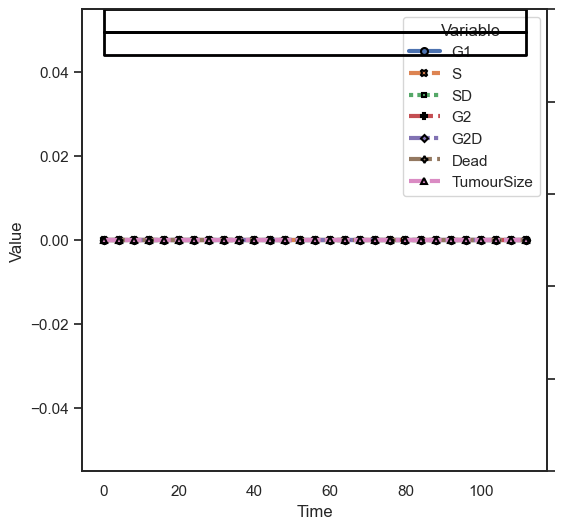

In [9]:
data_df_wide = myModel.resultsDf
variables_to_plot = ['G1', 'S', 'SD', 'G2', 'G2D', 'Dead', 'TumourSize']
data_df_long = pd.melt(data_df_wide, id_vars=['Time'], 
                  value_vars=myModel.stateVars + ["TumourSize"], 
                  var_name='Variable', value_name='Value')

fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.lineplot(x="Time", y="Value", hue="Variable", style="Variable",
             markers=True, linewidth=3, markersize=5, markeredgewidth=1.5, markeredgecolor='black',
             data=data_df_long[np.isin(data_df_long['Variable'], variables_to_plot)])
utils.plot_drug_bar(drug_data_df=data_df_wide, drug_columns=["Drug1_Concentration", "Drug2_Concentration"], drug_bar_position=0.9, 
              drugBarColours=sns.xkcd_palette(['ugly purple', 'baby poop green']),
              ax=ax)

In [4]:
data_df_wide

,Time,G1,S,SD,G2,G2D,Dead,A1,TumourSize,Drug1_Concentration,Drug2_Concentration
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
